<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/AbdelMahm/CORONA/blob/master/pca_corona_evolution.ipynb"><img src="https://colab.research.google.com/img/colab_favicon_256px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
import sys
import sklearn
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import urllib.request
from sklearn import preprocessing
from sklearn import pipeline
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

In [2]:
import urllib.request
corona_dataset_path = os.path.join("corona_dataset", "")
##pull data from ourworldindata
download_path = "https://covid.ourworldindata.org/data/ecdc/"
os.makedirs(corona_dataset_path, exist_ok=True)
for filename in ("total_cases.csv", "total_deaths.csv"):
    print("Downloading", filename)
    url = download_path + filename
    urllib.request.urlretrieve(url, corona_dataset_path + filename)

In [3]:
df_confirmed = pd.read_csv(corona_dataset_path + "total_cases.csv", thousands=',')
df_deaths = pd.read_csv(corona_dataset_path + "total_deaths.csv", thousands=',')
#df_recovered = pd.read_csv(corona_dataset_path + "time_series_19-covid-Recovered.csv", thousands=',')

In [4]:
df_confirmed.head()

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,United Kingdom,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Zambia,Zimbabwe
0,2019-12-31,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,2020-01-01,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2020-01-02,27,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2020-01-03,44,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,2020-01-04,44,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [5]:
df_deaths.head()

,date,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,...,United Kingdom,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Zambia,Zimbabwe
0,2019-12-31,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,2020-01-01,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,2020-01-02,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2020-01-03,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,2020-01-04,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [7]:
# transpose
df_confirmed = df_confirmed.T
df_deaths = df_deaths.T

In [8]:
#drop date row
df_confirmed = df_confirmed.drop(['date'])
df_deaths = df_deaths.drop(['date'])

In [9]:
#fill NANs
df_confirmed = df_confirmed.fillna(0)
df_deaths = df_deaths.fillna(0)

In [10]:
## Drop China and World

df_confirmed = df_confirmed.drop(['China'])
df_confirmed = df_confirmed.drop(['World'])


In [11]:
df_deaths = df_deaths.drop(['China'])
df_deaths = df_deaths.drop(['World'])

In [12]:
NZ_CONFIRMED = []
NZ_DEATHS = []
for country in df_deaths.index.values.tolist():
    nz_confirmed = df_confirmed.loc[country, df_confirmed.loc[country].to_numpy().nonzero()].to_list()
    nz_deaths = df_deaths.loc[country, df_deaths.loc[country].to_numpy().nonzero()].to_list()
    
    NZ_CONFIRMED.append(len(nz_confirmed))
    NZ_DEATHS.append(len(nz_deaths))
    
print(np.max(NZ_CONFIRMED))
print(np.max(NZ_DEATHS))

80
58


In [13]:
## Align to the appearance of the first case
def align_to_first_day(df, maxi):
    
    aligned = []
    countries = df.index.values.tolist()
    for country in df.index.values.tolist():
        nz = df.loc[country, df.loc[country].to_numpy().nonzero()].to_list()
        pad_nz = np.pad(nz, (0,np.max(maxi) - len(nz)), 'constant', constant_values=(0, 0))
        aligned.append(pad_nz)
    
    df_aligned= pd.DataFrame(data=aligned, index=df.index.values)
    
    return df_aligned

In [14]:
df_aligned_confirmed = align_to_first_day(df_confirmed, NZ_CONFIRMED)
df_aligned_deaths = align_to_first_day(df_deaths, NZ_DEATHS)

df_aligned_confirmed.head()
df_aligned_deaths.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
Afghanistan,1.0,1.0,1.0,1.0,2.0,3.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Albania,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,1.0,2.0,2.0,4.0,4.0,5.0,6.0,7.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Andorra,3.0,3.0,4.0,6.0,8.0,12.0,14.0,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


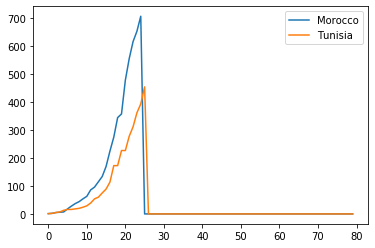

In [15]:
countries = ['Morocco', 'Tunisia', ]
for country in countries: #== targets[0] or country =='Algeria': #or country =='Spain' or country =='Iran' or country =='Japan' or country == 'United States':
    plt.plot(df_aligned_confirmed.loc[country])
plt.legend(countries)

## New aligned dataframes

In [80]:
def pca_move(df_name, country, compare_with = 'all', constant_size = True, day = 0):

    if df_name == 'confirmed':
        df = df_aligned_confirmed
    elif df_name == 'deaths':
        df = df_aligned_deaths
        
    X = df.iloc[:, 0:0+day+1]
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    pc = pca.fit_transform(X)
    df_pc = pd.DataFrame(data = pc, columns = ['PC1', 'PC2']).abs()
    
    MAX = np.max(df_pc)
    MIN = np.min(df_pc)
    #print(pca.explained_variance_ratio_)

    #==============================
    #plots configs
    #==============================
    plt.figure(1, figsize = (10,10))
    plt.ylim(-60 , 60)
    plt.xlim(-40 , 200)

    plt.xlabel('PC1', fontsize = 15)
    plt.ylabel('PC2', fontsize = 15)
    plt.title('2 component PCA', fontsize = 20)
    
    #==============================
    #setup options
    #==============================
    size = df.iloc[:, 0+day+1]
    #print(size)
    
    #==============================
    #main loop
    #==============================
    idx_country = df.index.get_loc(country)

    if compare_with == 'custom':
        
        europe_str = ['Turkey',
                      'Iran',
                      'Italy',
                      'Spain',
                      'United States',
                      'France'
                     ]
        europe = [df.index.get_loc('Turkey'), 
                  df.index.get_loc('Iran'),
                  df.index.get_loc('Italy'), 
                  df.index.get_loc('Spain'),
                  df.index.get_loc('United States'), 
                  df.index.get_loc('France'),
                 ]
        
        size = df.iloc[europe, 0+day+1]
        
        pc1 = df_pc.loc[europe, 'PC1']
        pc2 = df_pc.loc[europe, 'PC2']
        
        plt.scatter(pc1, 
                    pc2, 
                    c = 'green', 
                    s = 30 if constant_size else size/4.0 
                )

        plt.annotate(country, (df_pc.loc[idx_country, 'PC1']+.03, df_pc.loc[idx_country, 'PC2']+.03))
        for c in europe_str:
            idx_c = df.index.get_loc(c)
            plt.annotate(c, (df_pc.loc[idx_c, 'PC1']+.03, df_pc.loc[idx_c, 'PC2']+.03))
    
    elif compare_with == 'all':
        all_countries = df.index.values.tolist()
        size = df.iloc[:, 0+day+1]
        pc1 = df_pc.loc[:, 'PC1']
        pc2 = df_pc.loc[:, 'PC2']
        
        plt.scatter(pc1, 
                    pc2, 
                    c = 'red', 
                    s = 30 if constant_size else size/4.0 
                )

        plt.annotate(country, (df_pc.loc[idx_country, 'PC1']+.03, df_pc.loc[idx_country, 'PC2']+.03))
        for c in all_countries:
            idx_c = df.index.get_loc(c)
            plt.annotate(c, (df_pc.loc[idx_c, 'PC1']+.03, df_pc.loc[idx_c, 'PC2']+.03))

    else:
        idx_compare_with = df.index.get_loc(compare_with)
        pc1 = df_pc.loc[[idx_country, idx_compare_with], 'PC1']
        pc2 = df_pc.loc[[idx_country, idx_compare_with], 'PC2']
        plt.scatter(pc1, 
                    pc2, 
                    c = 'blue', 
                    s = 30 if constant_size else size 
                )

        plt.annotate(country, (df_pc.loc[idx_country, 'PC1']+.03, df_pc.loc[idx_country, 'PC2']+.03))
        plt.annotate(compare_with, (df_pc.loc[idx_compare_with, 'PC1']+.03, df_pc.loc[idx_compare_with, 'PC2']+.03))
   
    #==============================
    #plots
    #==============================
    title = 'day:' + str(day)
    plt.title(title)
    plt.grid()

    plt.show()
    
    return df_pc

In [81]:
%matplotlib inline
cw =df_aligned_confirmed.index.values.tolist()
cw.append('all')
cw.append('custom')
interactive_plot = interactive(pca_move, 
                               df_name = ['confirmed', 'deaths'],
                               country = df_aligned_confirmed.index.values.tolist(),
                               compare_with = cw,
                               constant_size = [True, False],
                               day =(1, 75)      
                              ) #
interactive_plot

In [63]:
def mwpca(df_name):

    if df_name == 'confirmed':
        df = df_aligned_confirmed
        NZ = NZ_CONFIRMED
    elif df_name == 'deaths':
        NZ = NZ_DEATHS
        df = df_aligned_deaths
    pc_all = []
    WINDOW = 14

    for day in range(0,np.max(NZ) - WINDOW):
        X = df.iloc[:, day:day+WINDOW]
        X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=2)
        pc = pca.fit_transform(X)
        pc_all.append(pc[:,0])
    
    pc_all = pd.DataFrame(data = pc_all).abs()
    
    return pc_all

Text(0.5, 1.0, 'deaths')

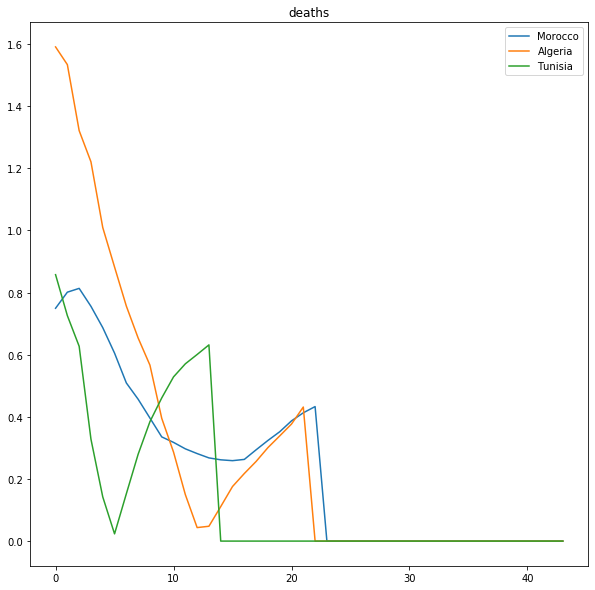

In [67]:
df_name= 'deaths'
df = df_aligned_deaths

#df_name= 'confirmed'
#df = df_aligned_confirmed

df_aligned_deaths_mask = (df_aligned_deaths != 0) * 1
sm = df_aligned_deaths_mask.sum(axis = 1)

plt.figure(1, figsize = (10,10))

ff = mwpca(df_name)

ff = ff.T
ff = ff.set_index(df.index.values)
ff = ff.mul(df_aligned_deaths_mask)

countries = [ 'Morocco', 'Tunisia', 'Algeria', 'Malaysia', 'France', 'United States','Spain', 'Italy']
countries = [ 'Morocco', 'Algeria', 'Tunisia']
#countries = df.index.values
mm = ff.loc[countries, :]

plt.plot(mm.T)
    
plt.legend(countries)
plt.title(df_name)

In [66]:

df_aligned_deaths_mask.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
Afghanistan,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Albania,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Algeria,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Andorra,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Angola,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Oxford

In [21]:
df_oxford = pd.read_csv(corona_dataset_path + "oxford.csv", thousands=',')
df_oxford.head()

,CountryName,CountryCode,Date,S1_School closing,S1_IsGeneral,S1_Notes,S2_Workplace closing,S2_IsGeneral,S2_Notes,S3_Cancel public events,...,S9_Monetary measures,S9_Notes,S10_Emergency investment in health care,S10_Notes,S11_Investment in Vaccines,S11_Notes,ConfirmedCases,ConfirmedDeaths,StringencyIndex,Unnamed: 34
0,Afghanistan,AFG,20200101,0.0,1.0,https://en.unesco.org/themes/education-emergen...,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,\t
1,Angola,AGO,20200101,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,\t
2,United Arab Emirates,ARE,20200101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,\t
3,Argentina,ARG,20200101,0.0,NaN,NaN,0.0,NaN,NaN,0.0,...,55.0,http://www.bcra.gov.ar/Institucional/Tasa_de_p...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,\t
4,Armenia,ARM,20200101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,\t


In [22]:
df_oxford_morocco = df_oxford[df_oxford['CountryCode'] == 'MAR']

In [23]:
df_oxford_morocco = df_oxford_morocco.fillna(0)
df_oxford_morocco.head(30)
df_oxford_morocco.sum()

CountryName                                MoroccoMoroccoMoroccoMoroccoMoroccoMoroccoMoro...
CountryCode                                MARMARMARMARMARMARMARMARMARMARMARMARMARMARMARM...
Date                                                                               424206708
S1_School closing                                                                          0
S1_IsGeneral                                                                               0
S1_Notes                                                                                   0
S2_Workplace closing                                                                       0
S2_IsGeneral                                                                               0
S2_Notes                                                                                   0
S3_Cancel public events                                                                    0
S3_IsGeneral                                                          